In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,VotingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os

#### Đọc dữ liệu 

In [2]:
data = pd.read_csv("train.csv").reset_index()
data.shape

(2000, 22)

 
- battery_power : tổng năng lượng mà pin có thể lưu trữ (mAh)
- blue : hổ trợ bluetooth (0-1)
- clock_speed : tốc độ mà bộ vi xử lý thực hiện các lệnh
- dual_sim : hổ trợ hai sim (0-1)
- fc : camera trước (mega pixel)
- four_g : hổ trợ 4G (0-1)
- int_memory : bộ nhớ trong (Gb)
- m_deep : chiều sâu của máy (cm)
- mobile_wt : trọng lượng của máy (g)

In [3]:
data.head()

,index,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,0,842,0,2.2,0,1,0,7,0.6,188,...,20,756,2549,9,7,19,0,0,1,1
1,1,1021,1,0.5,1,0,1,53,0.7,136,...,905,1988,2631,17,3,7,1,1,0,2
2,2,563,1,0.5,1,2,1,41,0.9,145,...,1263,1716,2603,11,2,9,1,1,0,2
3,3,615,1,2.5,0,0,0,10,0.8,131,...,1216,1786,2769,16,8,11,1,0,0,2
4,4,1821,1,1.2,0,13,1,44,0.6,141,...,1208,1212,1411,8,2,15,1,1,0,1


In [4]:
# Categorical features
cat_vals = ["blue", "dual_sim", "four_g", "wifi", "touch_screen", "three_g"] 
# Numerical features
num_vals = ["battery_power", "clock_speed", "fc", "int_memory", "m_dep", "mobile_wt",
            "n_cores", "pc", "px_height", "px_width", "ram",
            'sc_h', 'sc_w', 'talk_time'
           ]

In [5]:
# features
X = data[data.columns[1:-1]]
# target
Y = data[["price_range"]]

In [6]:
# Categorical features
X_cat = X[cat_vals]
# Numerical features
X_num = X[num_vals]

## Principal component analysis (Phân tích thành phần chính)

#### PCA - Categorical


In [7]:
pca = PCA(n_components=6)
pca.fit(X_cat)
X_transf= pca.transform(X_cat)

#### PCA - Numerical

In [8]:
scaler = MinMaxScaler()
X_num_scaled = scaler.fit_transform(X_num)
pca = PCA(n_components=14)
X_transf= pca.fit_transform(X_num_scaled)

In [9]:
pca = PCA(n_components=6)
X_transf= pca.fit_transform(X_num)

In [10]:
pca = PCA(n_components=4)
X_transf= pca.fit_transform(X_num)
data["X_PCA1"] = X_transf[:, 0]
data["X_PCA2"] = X_transf[:, 1]
data["X_PCA3"] = X_transf[:, 2]
data["X_PCA4"] = X_transf[:, 3]

In [11]:
# feature is now made of the four components of the PCA and the categorical values
features = ["X_PCA1", "X_PCA2", "X_PCA3", "X_PCA4"] + cat_vals
X_training = data[features]
X_training.head()

,X_PCA1,X_PCA2,X_PCA3,X_PCA4,blue,dual_sim,four_g,wifi,touch_screen,three_g
0,430.597105,-795.788278,-390.070331,55.636198,0,0,0,1,0,0
1,504.984729,696.622407,-235.629077,343.925952,1,1,1,0,1,1
2,473.329822,763.942174,-680.059464,-113.916908,1,1,1,0,1,1
3,639.822326,779.691218,-630.783687,-30.402214,1,0,0,0,0,1
4,-718.985171,382.304561,591.040320,-392.357215,1,0,1,0,1,1


In [12]:
# Chia dữ liệu ra Train - Test 67% 33%
X_train, X_test, y_train, y_test = train_test_split(X_training, Y, test_size=0.33,random_state=0)

In [13]:
# Change y shape for RandomForestClassifier
# ravel dàn phẳng từ mảng hai chiều sang mảng một chiều
y_train_fit = y_train.to_numpy().ravel()
print(y_train)
print(y_train_fit)

      price_range
295             1
364             0
862             2
1751            1
1403            2
...           ...
835             3
1216            1
1653            3
559             0
684             1

[1340 rows x 1 columns]
[1 0 2 ... 3 0 1]


## Random Forest (với tham số mặc định)

In [14]:
clf_RDF = RandomForestClassifier(random_state=0)
clf_RDF.fit(X_train, y_train_fit) # là một kiểu đối tượng RandomForestClassifier

RandomForestClassifier(random_state=0)

In [15]:
y_pred = clf_RDF.predict(X_test)
rs = accuracy_score(y_test,y_pred)
print(rs)

0.9045454545454545


Độ chính xác của thuật toán khá cao là 90,45%

 ##  Grid Search ( đi tìm siêu tham số)


In [16]:
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[None, 2, 5, 10, 15], "min_samples_split":(2, 3, 4) }
X_train, X_test, y_train, y_test = train_test_split(X_training, Y, test_size=0.33,random_state=0)
y_train_fit = y_train.to_numpy().ravel()
model = RandomForestClassifier(random_state=0)
clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train_fit)
print(clf.best_params_)
print(clf.best_score_)

{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}
0.8843283582089553


Grid Search mang lại kết quả chính xác là 88,43% không đem lại sự cải thiện hơn.

## Random Forest với siêu tham số

In [17]:
model = RandomForestClassifier(random_state=0,criterion=clf.best_params_['criterion'], max_depth= clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'])
X_train, X_test, y_train, y_test = train_test_split(X_training, Y, test_size=0.33,random_state=0)
y_train_fit = y_train.to_numpy().ravel()
model.fit(X_train, y_train_fit)
y_pred = model.predict(X_test)
# print(model.score(X_test,y_test))
rs = accuracy_score(y_test,y_pred)
print(rs)

0.9045454545454545


Sau khi sử dụng thuật toán RandomForest với siêu tham số vừa tìm được thì kết quả mang lại không thay đổi (90.45%)

## Chuẩn hóa dữ liệu 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_training, Y, test_size=0.33,random_state=0)
y_train_fit = y_train.to_numpy().ravel()
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(random_state=0, criterion=clf.best_params_['criterion'], max_depth= clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'])
model.fit(X_train, y_train_fit)
print(model.score(X_test,y_test))

0.906060606060606


Chuẩn hóa dữ liệu với MinmaxScaler mang lại kết quả tốt hơn 90,6%

### EDA (Phân tích khám phá dữ liệu)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2000 non-null   int64  
 1   battery_power  2000 non-null   int64  
 2   blue           2000 non-null   int64  
 3   clock_speed    2000 non-null   float64
 4   dual_sim       2000 non-null   int64  
 5   fc             2000 non-null   int64  
 6   four_g         2000 non-null   int64  
 7   int_memory     2000 non-null   int64  
 8   m_dep          2000 non-null   float64
 9   mobile_wt      2000 non-null   int64  
 10  n_cores        2000 non-null   int64  
 11  pc             2000 non-null   int64  
 12  px_height      2000 non-null   int64  
 13  px_width       2000 non-null   int64  
 14  ram            2000 non-null   int64  
 15  sc_h           2000 non-null   int64  
 16  sc_w           2000 non-null   int64  
 17  talk_time      2000 non-null   int64  
 18  three_g 

### Mối liên hệ giữa mức giá (price_range) và bộ nhớ Ram (ram_gb)

In [20]:
data['ram_gb']=data['ram']/1024
px.histogram(data,x='ram_gb',facet_col='price_range',marginal='box' )

Biểu đồ thể hiện chỉ số rõ ràng, giúp người nhìn có thể xác định mức giá của điện thoại thông qua Ram

In [21]:
data['ram_gb']=data['ram']/1024
px.scatter(data,x='ram_gb',y='int_memory',color='price_range',facet_col='touch_screen',facet_row='four_g')

Sự phân bổ rõ ràng có thể nhìn thấy ở đây là trong tất cả các ô thì riêng RAM có thể đủ để dự đoán giá của điện thoại

### Mối liên hệ giữa mức giá (price_range) và camera (fc: front camera - pc: primary camera)

In [22]:
px.scatter(data,x='pc',y='fc',color='price_range')

Điểm thú vị ở biểu đồ trên là : 
- Điện thoại có camera (trước và sau) nằm ở phân khúc giá rẻ (0 - màu xanh trên cùng bên phải)
- Điện thoại không có camera lại nằm ở phân khúc giá cao  (3 - màu vàng dưới cùng bên trái) 


Text(0.5, 1.0, 'Correlation ')

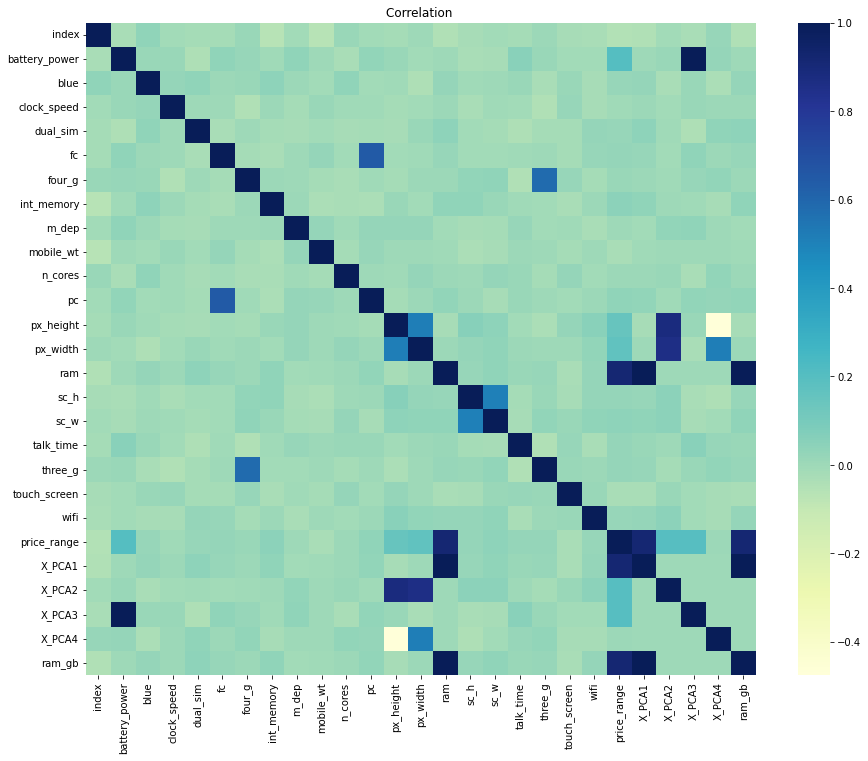

In [35]:
corr=data.corr()
fig = plt.figure(figsize=(15,12))
heatmap = sns.heatmap(corr, cmap='YlGnBu')
heatmap.set_title("Correlation ")

Các tính năng mà người dùng thường cân nhắc khi mua điện thoại là các tính năng ảnh hưởng đến mức giá của điện thoại như : 
- battery
- RAM
- pixel height-width
- number of cores
- memory